# Spaceship Titanic - V3 (EDA-Driven Features)

**V1:** CV 0.8265 / LB 0.8020 (overfitting)  
**V2:** CV 0.8141 / LB 0.8071 (clean, good ratio)  
**V3 Goal:** Add EDA-driven features that generalize well  

**New features from EDA:**
- Deck x Side interaction
- HomePlanet x Deck interaction  
- Fine age buckets (baby/child/teen/adult)
- Spending profile (% per category)
- Non-CryoSleep + NoSpend signal
- n_missing as feature
- Target encoding (CV-safe) for key categoricals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings, os

warnings.filterwarnings('ignore')

SEED = 42
N_FOLDS = 10
TARGET = 'Transported'

def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()
print('V3 Setup complete.')

V3 Setup complete.


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan
df = pd.concat([train, test], axis=0, ignore_index=True)

# Convert target to float early (True->1.0, False->0.0, NaN stays NaN)
df[TARGET] = df[TARGET].map({True: 1.0, False: 0.0})

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print(f'Combined: {df.shape}')

Combined: (12970, 15)


## Feature Engineering V3

In [3]:
# ============================================================
# STEP 1: Parse raw columns
# ============================================================

# PassengerId -> Group, GroupSize
df['_Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
df['GroupSize'] = df.groupby('_Group')['PassengerId'].transform('count')
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

# Cabin -> Deck, CabinNum, Side
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
df['Side'] = df['Cabin'].str.split('/').str[2]

# Name -> Surname, FamilySize
df['Surname'] = df['Name'].str.split().str[-1]
df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
df.loc[df['Surname'].isna(), 'FamilySize'] = 1

# Booleans
df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})

print('Step 1 done: raw parsing')

Step 1 done: raw parsing


In [4]:
# ============================================================
# STEP 2: Smart imputation BEFORE feature engineering
# ============================================================

# CryoSleep passengers must have 0 spending
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0

# Infer CryoSleep from spending
total_spend_raw = df[spend_cols].sum(axis=1)
df.loc[(df['CryoSleep'].isna()) & (total_spend_raw == 0), 'CryoSleep'] = 1
df.loc[(df['CryoSleep'].isna()) & (total_spend_raw > 0), 'CryoSleep'] = 0

# HomePlanet can be inferred from Deck (EDA insight)
# Europa -> B,C,A,T ; Earth -> F,G,E(partial) ; Mars -> F,D,E(partial)
deck_to_planet = {
    'A': 'Europa', 'B': 'Europa', 'C': 'Europa', 'T': 'Europa',
    'G': 'Earth'
}
for deck, planet in deck_to_planet.items():
    mask = (df['HomePlanet'].isna()) & (df['Deck'] == deck)
    df.loc[mask, 'HomePlanet'] = planet

# Fill remaining with median/mode
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

print(f'Step 2 done: imputation. Nulls remaining: {df.isnull().sum().sum()}')

Step 2 done: imputation. Nulls remaining: 0


In [5]:
# ============================================================
# STEP 3: Spending features (EDA-driven)
# ============================================================

# Total and log transforms
df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)

for col in spend_cols:
    df[f'{col}_log'] = np.log1p(df[col])

# NEW: Spending PROFILE (% per category) - EDA showed this discriminates
for col in spend_cols:
    df[f'{col}_pct'] = df[col] / (df['TotalSpend'] + 1)

# NEW: Luxury vs Basic (EDA: not-transported = luxury spenders)
df['LuxurySpend'] = df['RoomService'] + df['Spa'] + df['VRDeck']
df['BasicSpend'] = df['FoodCourt'] + df['ShoppingMall']
df['LuxurySpend_log'] = np.log1p(df['LuxurySpend'])
df['BasicSpend_log'] = np.log1p(df['BasicSpend'])
df['LuxuryRatio'] = df['LuxurySpend'] / (df['TotalSpend'] + 1)

# NEW: Binary spending flags
df['HasLuxurySpend'] = (df['LuxurySpend'] > 0).astype(int)
df['HasBasicSpend'] = (df['BasicSpend'] > 0).astype(int)

# NEW: Non-CryoSleep with no spending (EDA: 62% transported)
df['Awake_NoSpend'] = ((df['CryoSleep'] == 0) & (df['TotalSpend'] == 0)).astype(int)

print('Step 3 done: spending features')

Step 3 done: spending features


In [6]:
# ============================================================
# STEP 4: Age features (EDA-driven fine buckets)
# ============================================================

# Fine age buckets based on EDA
df['IsBaby'] = (df['Age'] <= 4).astype(float)      # 81% transported
df['IsChild'] = ((df['Age'] > 4) & (df['Age'] < 13)).astype(float)  # ~65% transported
df['IsTeen'] = ((df['Age'] >= 13) & (df['Age'] < 18)).astype(float)  # ~55%
df['IsYoungAdult'] = ((df['Age'] >= 18) & (df['Age'] < 30)).astype(float)
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 4, 12, 17, 30, 50, 80],
                        labels=[0, 1, 2, 3, 4, 5]).astype(float)

# NEW: Children under 13 cannot spend on certain things
df['IsMinor'] = (df['Age'] < 13).astype(float)  # baby + child

print('Step 4 done: age features')

Step 4 done: age features


In [7]:
# ============================================================
# STEP 5: Cabin features (EDA-driven interactions)
# ============================================================

# Broad cabin region (not too granular)
df['CabinRegion'] = (df['CabinNum'] // 100).astype(float)

# NEW: Deck x Side interaction (EDA showed some combos very predictive)
df['DeckSide'] = df['Deck'] + '_' + df['Side']

# NEW: HomePlanet x Deck interaction (EDA: HP determines Deck)
df['PlanetDeck'] = df['HomePlanet'] + '_' + df['Deck']

# NEW: HomePlanet x Destination
df['PlanetDest'] = df['HomePlanet'] + '_' + df['Destination']

print('Step 5 done: cabin interactions')

Step 5 done: cabin interactions


In [8]:
# ============================================================
# STEP 6: n_missing and data quality features
# ============================================================

# We need original data for this, reload briefly
train_orig = pd.read_csv('../data/train.csv')
test_orig = pd.read_csv('../data/test.csv')
test_orig[TARGET] = np.nan
df_orig = pd.concat([train_orig, test_orig], axis=0, ignore_index=True)

df['n_missing'] = df_orig.isnull().sum(axis=1)
df['has_missing'] = (df['n_missing'] > 0).astype(int)

del train_orig, test_orig, df_orig
print('Step 6 done: missing features')

Step 6 done: missing features


In [9]:
# ============================================================
# STEP 7: Group-level features (safe, no survival leakage)
# ============================================================

# Group spending (computed on combined train+test = no leakage)
df['GroupSpend_mean_log'] = np.log1p(df.groupby('_Group')['TotalSpend'].transform('mean'))
df['GroupSpend_std'] = df.groupby('_Group')['TotalSpend'].transform('std').fillna(0)

# Group age stats
df['GroupAge_mean'] = df.groupby('_Group')['Age'].transform('mean')
df['GroupAge_std'] = df.groupby('_Group')['Age'].transform('std').fillna(0)

# Group CryoSleep rate (from combined data = safe)
df['GroupCryo_rate'] = df.groupby('_Group')['CryoSleep'].transform('mean')

print('Step 7 done: group features')

Step 7 done: group features


In [10]:
# ============================================================
# STEP 8: Encode all categoricals
# ============================================================

# Label encode low-cardinality categoricals
label_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
for col in label_cols:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col].astype(str))

# Frequency encode (low cardinality = safe)
for col in label_cols:
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

# NEW: Frequency encode interaction features
for col in ['DeckSide', 'PlanetDeck', 'PlanetDest']:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col].astype(str))
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

print('Step 8 done: encoding')

Step 8 done: encoding


In [11]:
# ============================================================
# STEP 9: Target encoding (CV-safe) for key categoricals
# ============================================================

train_mask = df['is_train'] == 1
train_idx = df[train_mask].index
test_idx = df[~train_mask].index

te_cols = ['DeckSide', 'PlanetDeck', 'PlanetDest', 'Deck']
kf_te = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
y_train_te = df.loc[train_idx, TARGET].astype(int).values

for col in te_cols:
    df[col + '_te'] = 0.5  # initialize with prior
    global_mean = float(y_train_te.mean())
    
    # OOF target encoding for train
    for fold_train, fold_val in kf_te.split(train_idx, y_train_te):
        fold_train_idx = train_idx[fold_train]
        fold_val_idx = train_idx[fold_val]
        
        means = df.loc[fold_train_idx].groupby(col)[TARGET].mean()
        mapped = df.loc[fold_val_idx, col].map(means).fillna(global_mean)
        df.loc[fold_val_idx, col + '_te'] = mapped.values
    
    # For test: use full train
    means = df.loc[train_idx].groupby(col)[TARGET].mean()
    mapped = df.loc[test_idx, col].map(means).fillna(global_mean)
    df.loc[test_idx, col + '_te'] = mapped.values

print('Step 9 done: target encoding')

Step 9 done: target encoding


In [12]:
# ============================================================
# DEFINE FINAL FEATURES
# ============================================================

drop_cols = [
    'PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
    'HomePlanet', 'Destination', 'Deck', 'Side',
    '_Group', 'CabinNum',
    'TotalSpend', 'LuxurySpend', 'BasicSpend', 'GroupSpend_std',
    'DeckSide', 'PlanetDeck', 'PlanetDest',
] + spend_cols

features = [c for c in df.columns if c not in drop_cols]
print(f'V3 features: {len(features)}')
print()
for i, f in enumerate(sorted(features)):
    print(f'  {i+1:2d}. {f}')

V3 features: 56

   1. Age
   2. AgeGroup
   3. Awake_NoSpend
   4. BasicSpend_log
   5. CabinRegion
   6. CryoSleep
   7. DeckSide_freq
   8. DeckSide_le
   9. DeckSide_te
  10. Deck_freq
  11. Deck_le
  12. Deck_te
  13. Destination_freq
  14. Destination_le
  15. FamilySize
  16. FoodCourt_log
  17. FoodCourt_pct
  18. GroupAge_mean
  19. GroupAge_std
  20. GroupCryo_rate
  21. GroupSize
  22. GroupSpend_mean_log
  23. HasBasicSpend
  24. HasLuxurySpend
  25. HomePlanet_freq
  26. HomePlanet_le
  27. IsAlone
  28. IsBaby
  29. IsChild
  30. IsMinor
  31. IsTeen
  32. IsYoungAdult
  33. LuxuryRatio
  34. LuxurySpend_log
  35. NoSpend
  36. NumServicesUsed
  37. PlanetDeck_freq
  38. PlanetDeck_le
  39. PlanetDeck_te
  40. PlanetDest_freq
  41. PlanetDest_le
  42. PlanetDest_te
  43. RoomService_log
  44. RoomService_pct
  45. ShoppingMall_log
  46. ShoppingMall_pct
  47. Side_freq
  48. Side_le
  49. Spa_log
  50. Spa_pct
  51. TotalSpend_log
  52. VIP
  53. VRDeck_log
  54. VRDeck_p

In [13]:
# Split
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].values.astype(int)
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')
print(f'Target: {np.mean(y):.4f}')

X: (8693, 56), y: (8693,), X_test: (4277, 56)
Target: 0.5036


## LightGBM V3

In [14]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 24,
    'learning_rate': 0.03,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_child_samples': 25,
    'reg_alpha': 0.3,
    'reg_lambda': 1.5,
    'max_depth': 5,
    'n_estimators': 5000,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': SEED,
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
fi_lgb = np.zeros(len(features))

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)]
    )
    
    oof_lgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    fi_lgb += model.feature_importances_ / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_lgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
print(f'\nLightGBM V3 CV: {lgb_acc:.5f}')

Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.385309
Early stopping, best iteration is:
[464]	valid_0's binary_logloss: 0.384202
Fold 1/10 - Accuracy: 0.80230
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.354364
Early stopping, best iteration is:
[330]	valid_0's binary_logloss: 0.352361
Fold 2/10 - Accuracy: 0.83678
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.359038
Fold 3/10 - Accuracy: 0.83448
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.420828
Early stopping, best iteration is:
[628]	valid_0's binary_logloss: 0.419224


Fold 4/10 - Accuracy: 0.78481
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.361494
Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 0.3601
Fold 5/10 - Accuracy: 0.82278
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.386599
Early stopping, best iteration is:
[484]	valid_0's binary_logloss: 0.385978
Fold 6/10 - Accuracy: 0.81358
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.352512
Early stopping, best iteration is:
[573]	valid_0's binary_logloss: 0.350765
Fold 7/10 - Accuracy: 0.84465
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.36645
Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.363876
Fold 8/10 - Accuracy: 0.81933
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.391848
Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.389074
Fold 9/10 - Accuracy: 0.80207
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.404529
Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.399944
Fold 10/10 - Accuracy: 0.80207

LightGBM V3 CV: 0.81629


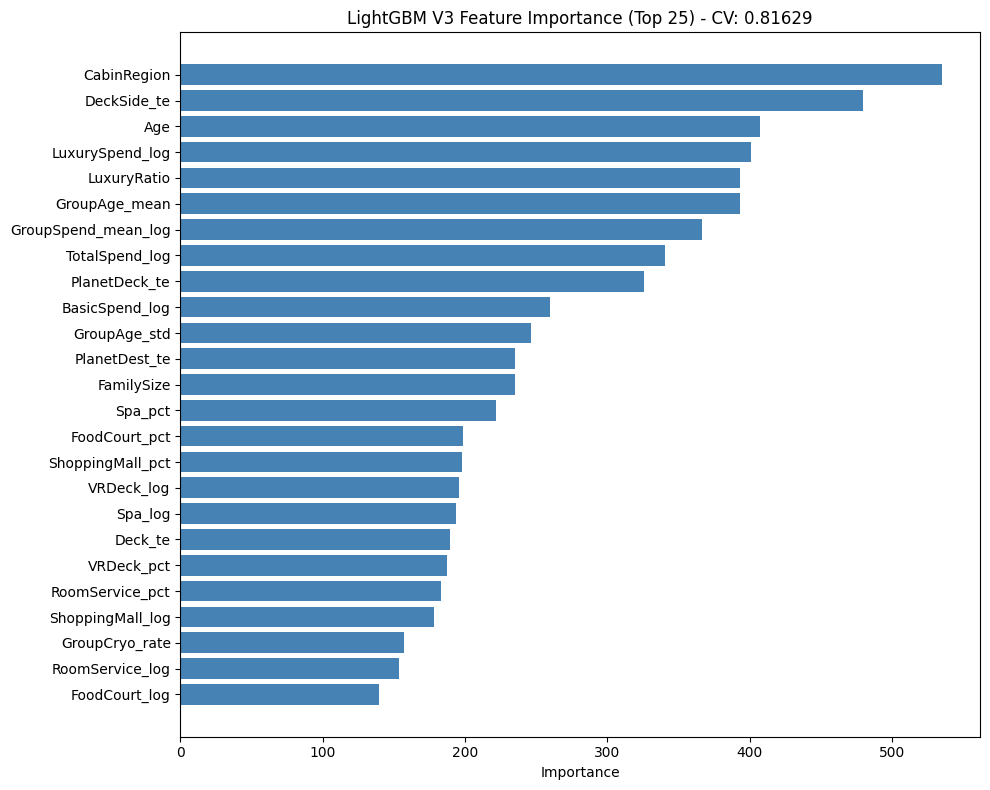

In [15]:
# Feature importance
fi_df = pd.DataFrame({'feature': features, 'importance': fi_lgb})
fi_df = fi_df.sort_values('importance', ascending=True).tail(25)

plt.figure(figsize=(10, 8))
plt.barh(fi_df['feature'], fi_df['importance'], color='steelblue')
plt.title(f'LightGBM V3 Feature Importance (Top 25) - CV: {lgb_acc:.5f}')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## XGBoost V3

In [16]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 8,
    'reg_alpha': 0.3,
    'reg_lambda': 1.5,
    'gamma': 0.05,
    'n_estimators': 5000,
    'early_stopping_rounds': 200,
    'tree_method': 'hist',
    'random_state': SEED,
    'verbosity': 0,
}

oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=500)
    
    oof_xgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_xgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
print(f'\nXGBoost V3 CV: {xgb_acc:.5f}')

[0]	validation_0-logloss:0.67977


[500]	validation_0-logloss:0.38255


[728]	validation_0-logloss:0.38385


Fold 1/10 - Accuracy: 0.79655
[0]	validation_0-logloss:0.67967


[464]	validation_0-logloss:0.35322


Fold 2/10 - Accuracy: 0.83793
[0]	validation_0-logloss:0.67950


[458]	validation_0-logloss:0.36029


Fold 3/10 - Accuracy: 0.82299
[0]	validation_0-logloss:0.68132


[500]	validation_0-logloss:0.42314


[758]	validation_0-logloss:0.42516


Fold 4/10 - Accuracy: 0.78481
[0]	validation_0-logloss:0.68004


[500]	validation_0-logloss:0.36216


[642]	validation_0-logloss:0.36193


Fold 5/10 - Accuracy: 0.82509
[0]	validation_0-logloss:0.68028


[500]	validation_0-logloss:0.38518


[867]	validation_0-logloss:0.38465


Fold 6/10 - Accuracy: 0.81588
[0]	validation_0-logloss:0.67974


[500]	validation_0-logloss:0.35087


[619]	validation_0-logloss:0.35167


Fold 7/10 - Accuracy: 0.84120
[0]	validation_0-logloss:0.67948


[500]	validation_0-logloss:0.36644


[812]	validation_0-logloss:0.36939


Fold 8/10 - Accuracy: 0.82509
[0]	validation_0-logloss:0.67986


[456]	validation_0-logloss:0.39194


Fold 9/10 - Accuracy: 0.79977
[0]	validation_0-logloss:0.68083


[500]	validation_0-logloss:0.40671


[525]	validation_0-logloss:0.40748


Fold 10/10 - Accuracy: 0.79977

XGBoost V3 CV: 0.81491


## CatBoost V3

In [17]:
oof_cb = np.zeros(len(X))
test_cb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.03,
        depth=5,
        l2_leaf_reg=4.0,
        subsample=0.7,
        colsample_bylevel=0.7,
        min_data_in_leaf=25,
        random_seed=SEED,
        verbose=500,
        early_stopping_rounds=200,
        task_type='CPU',
    )
    
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    
    oof_cb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_cb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
print(f'\nCatBoost V3 CV: {cb_acc:.5f}')

0:	learn: 0.6779474	test: 0.6782280	best: 0.6782280 (0)	total: 155ms	remaining: 12m 54s


500:	learn: 0.3263482	test: 0.3858366	best: 0.3857346 (468)	total: 1.17s	remaining: 10.5s


1000:	learn: 0.2746485	test: 0.3815404	best: 0.3814459 (998)	total: 2.19s	remaining: 8.75s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3813445711
bestIteration = 1015

Shrink model to first 1016 iterations.
Fold 1/10 - Accuracy: 0.81149
0:	learn: 0.6782545	test: 0.6772916	best: 0.6772916 (0)	total: 2.86ms	remaining: 14.3s


500:	learn: 0.3270723	test: 0.3486246	best: 0.3484068 (490)	total: 1.02s	remaining: 9.17s


1000:	learn: 0.2765336	test: 0.3427859	best: 0.3422701 (957)	total: 2.03s	remaining: 8.1s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3419306139
bestIteration = 1053

Shrink model to first 1054 iterations.
Fold 2/10 - Accuracy: 0.83563
0:	learn: 0.6790618	test: 0.6781055	best: 0.6781055 (0)	total: 2.29ms	remaining: 11.4s


500:	learn: 0.3267774	test: 0.3570419	best: 0.3567966 (488)	total: 1.02s	remaining: 9.15s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3556690696
bestIteration = 698

Shrink model to first 699 iterations.
Fold 3/10 - Accuracy: 0.82989
0:	learn: 0.6775143	test: 0.6793692	best: 0.6793692 (0)	total: 1.85ms	remaining: 9.25s


500:	learn: 0.3232821	test: 0.4223437	best: 0.4223337 (496)	total: 1.02s	remaining: 9.17s


1000:	learn: 0.2729620	test: 0.4183065	best: 0.4182179 (995)	total: 2.01s	remaining: 8.04s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.417939025
bestIteration = 1021

Shrink model to first 1022 iterations.
Fold 4/10 - Accuracy: 0.78021
0:	learn: 0.6783129	test: 0.6775262	best: 0.6775262 (0)	total: 1.86ms	remaining: 9.29s


500:	learn: 0.3276249	test: 0.3611922	best: 0.3611519 (463)	total: 1.02s	remaining: 9.16s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3593288215
bestIteration = 609

Shrink model to first 610 iterations.
Fold 5/10 - Accuracy: 0.81588
0:	learn: 0.6751233	test: 0.6759166	best: 0.6759166 (0)	total: 2.57ms	remaining: 12.8s


500:	learn: 0.3251654	test: 0.3877101	best: 0.3874578 (497)	total: 1.07s	remaining: 9.64s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3865526595
bestIteration = 680

Shrink model to first 681 iterations.
Fold 6/10 - Accuracy: 0.82278
0:	learn: 0.6756755	test: 0.6752912	best: 0.6752912 (0)	total: 2.52ms	remaining: 12.6s


500:	learn: 0.3302413	test: 0.3522810	best: 0.3521760 (499)	total: 1.02s	remaining: 9.21s


1000:	learn: 0.2772384	test: 0.3483774	best: 0.3482527 (973)	total: 2.02s	remaining: 8.09s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3482526988
bestIteration = 973

Shrink model to first 974 iterations.
Fold 7/10 - Accuracy: 0.83314
0:	learn: 0.6781186	test: 0.6782854	best: 0.6782854 (0)	total: 1.97ms	remaining: 9.84s


500:	learn: 0.3267810	test: 0.3697578	best: 0.3695407 (478)	total: 1.02s	remaining: 9.16s


1000:	learn: 0.2772238	test: 0.3672756	best: 0.3671405 (981)	total: 2.04s	remaining: 8.16s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3669554418
bestIteration = 1011

Shrink model to first 1012 iterations.
Fold 8/10 - Accuracy: 0.82163
0:	learn: 0.6780635	test: 0.6786274	best: 0.6786274 (0)	total: 1.78ms	remaining: 8.92s


500:	learn: 0.3257971	test: 0.3891118	best: 0.3887575 (430)	total: 1.02s	remaining: 9.13s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3877509157
bestIteration = 579

Shrink model to first 580 iterations.
Fold 9/10 - Accuracy: 0.80092
0:	learn: 0.6779750	test: 0.6785689	best: 0.6785689 (0)	total: 2.28ms	remaining: 11.4s


500:	learn: 0.3228994	test: 0.4061123	best: 0.4059587 (396)	total: 999ms	remaining: 8.97s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4059587151
bestIteration = 396

Shrink model to first 397 iterations.


Fold 10/10 - Accuracy: 0.79056

CatBoost V3 CV: 0.81422


## Ensemble & Submission

In [18]:
print('=== V3 Results ===')
print(f'LightGBM: {lgb_acc:.5f}')
print(f'XGBoost:  {xgb_acc:.5f}')
print(f'CatBoost: {cb_acc:.5f}')

# Simple average (safest)
oof_avg = (oof_lgb + oof_xgb + oof_cb) / 3
avg_acc = accuracy_score(y, (oof_avg > 0.5).astype(int))
print(f'\nSimple Average: {avg_acc:.5f}')

# Majority voting
votes = ((oof_lgb > 0.5).astype(int) + (oof_xgb > 0.5).astype(int) + (oof_cb > 0.5).astype(int))
vote_acc = accuracy_score(y, (votes >= 2).astype(int))
print(f'Majority Voting: {vote_acc:.5f}')

# Use simple average for submission
final_proba = (test_lgb + test_xgb + test_cb) / 3
final_preds = (final_proba > 0.5)

print(f'\nTest: {final_preds.sum()} True / {len(final_preds) - final_preds.sum()} False')
print(f'Ratio: {final_preds.mean():.4f}')

print(f'\n=== VERSION COMPARISON ===')
print(f'V1: CV 0.82653 | LB 0.80196 | Gap 0.0246')
print(f'V2: CV 0.81410 | LB 0.80710 | Gap 0.0070')
print(f'V3: CV {avg_acc:.5f} | LB TBD')

=== V3 Results ===
LightGBM: 0.81629
XGBoost:  0.81491
CatBoost: 0.81422

Simple Average: 0.81836
Majority Voting: 0.81560

Test: 2190 True / 2087 False
Ratio: 0.5120

=== VERSION COMPARISON ===
V1: CV 0.82653 | LB 0.80196 | Gap 0.0246
V2: CV 0.81410 | LB 0.80710 | Gap 0.0070
V3: CV 0.81836 | LB TBD


In [19]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_preds
})
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('../submissions/submission_v3.csv', index=False)

assert submission.shape[0] == sample_sub.shape[0]
assert list(submission.columns) == list(sample_sub.columns)
assert submission['Transported'].dtype == bool

print('V3 Submission saved: submissions/submission_v3.csv')
print(submission['Transported'].value_counts(normalize=True))
submission.head()

V3 Submission saved: submissions/submission_v3.csv
Transported
True     0.512041
False    0.487959
Name: proportion, dtype: float64


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
